# RRAM Relaxation Data Notebook

This notebook contains the analysis on empirical RRAM relaxation data across three technologies (A, B, C). It loads and processes the measurements taken for each technology.

In [132]:
# Imports
import glob
import json
import os.path
import shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal
from matplotlib.offsetbox import AnchoredText

## Load the data and settings

Below, choose which technology to load data and settings for:

In [4]:
# Choose technology here
TECH = "C"
FULLDATA = False

# Load settings for technology
with open(f"data/tech{TECH}/settings.json") as sfile:
    settings = json.load(sfile)

# Load data for technology
colnames = ["addr", "time", "r", "g"]
if FULLDATA: # Load full dataset
    data = pd.read_csv(f"data/tech{TECH}/relaxdata.tsv.gz", names=colnames, sep='\t')
    tsdata = pd.read_csv(f"data/tech{TECH}/tsdata.tsv.gz", names=colnames, sep='\t')
else: # Load small dataset (only includes data that will actually be used)
    data = pd.read_csv(f"data/tech{TECH}/relaxdata.tsv.gz", names=colnames, sep='\t')
    tsdata = pd.read_csv(f"data/tech{TECH}/tsdata.min.tsv.gz", names=colnames, sep='\t')

## Power Spectral Density
The code below generates the power spectral density plot:

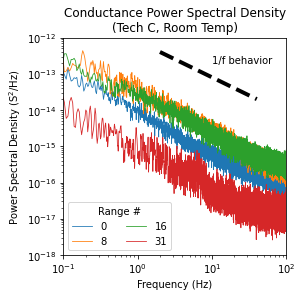

In [405]:
# Get ranges to plot PSD for
ranges = np.array([0, 8, 16, 31])

# Get addrs to plot PSD for
if FULLDATA:
    # Use PSD index offsets to select the correct cells
    indices = ranges + np.array(settings["psdIndexOffsets"]) * 32

    # Output data to small file
    fopts = {"sep": '\t', "header": False, "index": False}
    tsdata[tsdata["addr"].isin(addrs)].to_csv(f"data/tech{TECH}/tsdata.min.tsv.gz", **fopts)
else:
    # Use indices sequentially if using minimal data set
    indices = range(len(ranges))
addrs = tsdata[tsdata["time"] == 0]["addr"].to_numpy()[indices]

# Compute PSD
def psd(tmin, tmax, linewidth=0.8):
    # Plot long-term power spectral density (PSD)
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_title(f"Conductance Power Spectral Density\n(Tech {TECH}, Room Temp)")
    slopes = []
    for r, addr in zip(ranges, addrs):
        # Select data
        d = tsdata[(tsdata["addr"] == addr) & (tsdata["time"] > tmin) & (tsdata["time"] < tmax)]

        # # Lomb-Scargle PSD
        # f = np.logspace(np.log10(1/600), np.log10(2), 500)
        # f = np.logspace(np.log10(2), np.log10(400/2), 1000)
        # p = scipy.signal.lombscargle(d["time"], d["g"], f)

        # Welch PSD
        f, p = scipy.signal.welch(d["g"], fs=settings["fs"], nperseg=settings["psdnperseg"])
        plt.plot(f, p, label=r, linewidth=linewidth)

        # # Power law fit
        # a, b = np.polyfit(np.log(f[[30,-30]]), np.log(p[[30,-30]]), 1)
        # print(f"Range {r} slope: {a}")
        # slopes.append(a)
        # plt.plot(f[1:], np.exp(a*np.log(f[1:]) + b), 'k--', zorder=10, linewidth=2)

        # # 1/f fit
        # fitfn = lambda logf, A: A - logf
        # params, _ = scipy.optimize.curve_fit(fitfn, np.log(f), np.log(p))
        # A = params[0]
        # print(A)
        # plt.plot(f, np.exp(fitfn(np.log(f), A)), 'k--', zorder=10, linewidth=2)

    # Format and display
    # ax.add_artist(AnchoredText("Slopes: [%.2f, %.2f]" % (max(slopes), min(slopes)), loc=1, frameon=False))
    plt.plot(*settings["psdFpts"], 'k--', zorder=10, linewidth=4)
    ax.legend(title="Range #", ncol=2)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Power Spectral Density (S$^2$/Hz)")
    ax.set_xscale("log")
    ax.set_xlim(*settings["psdxlim"])
    ax.set_ylim(*settings["psdylim"])
    ax.set_yscale("log")
    plt.text(*settings["psdFtextloc"], "1/f behavior")
    plt.show()

# Do for short and long-term
psd(0, 1e10)